In [362]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd

import wfdb

from sktime.utils.plotting import plot_series
from sktime.distances import (
        euclidean_distance,
        dtw_distance
    )

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from numba import jit, njit

import matplotlib.pyplot as plt

import os

from tqdm.notebook import tqdm

from typing import Callable

In [363]:
DATA_FILE: str = "datasets/MIT-BIH Arrhythmia.parquet"

Leitura de todas as séries

In [364]:
if not os.path.isfile(DATA_FILE):
    record_list: list[str] = wfdb.get_record_list('mitdb')

    all_records: list[pd.DataFrame] = []

    cur_iter: int = 1
    for record_name in record_list:
        print(f'{cur_iter}/{len(record_list)}', end='\r')
        cur_iter += 1

        rec: pd.DataFrame = wfdb.rdrecord(record_name, pn_dir='mitdb').to_dataframe()
        ann: wfdb.Annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')

        values: np.ndarray = np.full(len(rec), None)
        values[ann.sample] = ann.symbol
        rec['type'] = values

        values: np.ndarray = np.full(len(rec), None)
        values[ann.sample] = ann.subtype
        rec['sub'] = values

        values: np.ndarray = np.full(len(rec), None)
        values[ann.sample] = ann.chan
        rec['chan'] = values

        values: np.ndarray = np.full(len(rec), None)
        values[ann.sample] = ann.num
        rec['num'] = values

        all_records.append(rec)

    records: pd.DataFrame = pd.concat(all_records, axis=1, keys=record_list)
    records.to_parquet(DATA_FILE)

records: pd.DataFrame = pd.read_parquet(DATA_FILE)
record_list: list[str] = records.columns.map(lambda x: x[0]).unique().tolist()
display(records.head())

100                              101              \
                            MLII     V5  type sub chan num   MLII    V1  type   
0 days 00:00:00           -0.145 -0.065  None NaN  NaN NaN -0.345 -0.16  None   
0 days 00:00:00.002777777 -0.145 -0.065  None NaN  NaN NaN -0.345 -0.16  None   
0 days 00:00:00.005555554 -0.145 -0.065  None NaN  NaN NaN -0.345 -0.16  None   
0 days 00:00:00.008333331 -0.145 -0.065  None NaN  NaN NaN -0.345 -0.16  None   
0 days 00:00:00.011111108 -0.145 -0.065  None NaN  NaN NaN -0.345 -0.16  None   

                               ...   233                  234               \
                          sub  ...  type  sub chan  num  MLII     V1  type   
0 days 00:00:00           NaN  ...  None  NaN  NaN  NaN -0.08  0.135  None   
0 days 00:00:00.002777777 NaN  ...  None  NaN  NaN  NaN -0.08  0.135  None   
0 days 00:00:00.005555554 NaN  ...  None  NaN  NaN  NaN -0.08  0.135  None   
0 days 00:00:00.008333331 NaN  ...     +  0.0  0.0  0.0 -0.08  0.135  None   
0 days 00:00:00.011111108 NaN  ...  None  NaN  NaN  NaN -0.08  0.135  None   

                                        
                          sub chan num  
0 days 00:00:00           NaN  NaN NaN  
0 days 00:00:00.002777777 NaN  NaN NaN  
0 days 00:00:00.005555554 NaN  NaN NaN  
0 days 00:00:00.008333331 NaN  NaN NaN  
0 days 00:00:00.011111108 NaN  NaN NaN  

[5 rows x 288 columns]

Escolha da série utilizada

Number of sections: 173


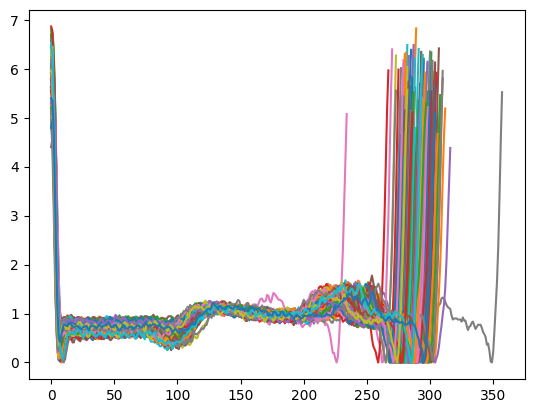

In [390]:
record: pd.DataFrame = records['100'].head(50000) ## Using only some of them
record = record.reset_index(names='timestamp')

series_used: np.ndarray = record['MLII'].to_numpy()

cycles = record.dropna().index.to_numpy()
print(f"Number of sections: {len(cycles)}")

def preprocess(series: np.ndarray) -> np.ndarray:
    series = series.copy()
    series = series - series.min()
    series = series / series.mean()
    return series

sections: list[np.ndarray] = []
for i in range(1, len(cycles) - 1):
    sections.append(preprocess(series_used[cycles[i]:cycles[i+1]]))
    plt.plot(sections[-1])
plt.show()

Divisão dos batimentos

In [366]:
def get_distance_matrix(series_list: list[np.ndarray], distance_fn) -> np.ndarray:
    n: int = len(series_list)
    distances: np.ndarray = np.zeros((n, n))

    for i in tqdm(range(n)):
        distances[i, i] = 0
        cur: int = 1
        total: int = n - (i+1)
        for j in range(i+1, n):
            tqdm.write(f'             ', end='\r')
            tqdm.write(f'{cur}/{total}', end='\r')
            cur += 1
            distances[i, j] = distances[j, i] = distance_fn(series_list[i], series_list[j])

        tqdm.write(f'             ', end='\r')

    return distances

def euclidean_ts(s1: np.ndarray, s2: np.ndarray) -> float:
    max_len: int = min(len(s1), len(s2))
    s1 = s1[:max_len]
    s2 = s2[:max_len]

    return euclidean(s1, s2)

def dtw_ts(s1: np.ndarray, s2: np.ndarray) -> float:
    dist, _ = fastdtw(s1, s2)
    return dist

euclidean_distances: np.ndarray = get_distance_matrix(sections, euclidean_ts)
dtw_distances: np.ndarray = get_distance_matrix(sections, dtw_ts)

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

In [367]:
np.save("euclidean_distances100.npy", euclidean_distances)
np.save("dtw_distances100.npy", dtw_distances)

In [392]:
euclidean_distances = np.load("euclidean_distances100.npy")
dtw_distances = np.load("dtw_distances100.npy")

In [369]:
def get_anomalies(distances: np.ndarray, expected_proportion: float = 0.005) -> np.ndarray:
    distances = distances.copy()
    distances.sort(1)

    last_percentage: int = int(len(distances)*expected_proportion)
    return np.argpartition(distances[:, 2], -last_percentage)[-last_percentage:]

def get_non_anomalies(distances: np.ndarray, expected_proportion: float = 0.005) -> np.ndarray:
    distances = distances.copy()
    distances.sort(1)

    last_percentage: int = int(len(distances)*expected_proportion)
    return np.argpartition(distances[:, 2], last_percentage)[:last_percentage+1]

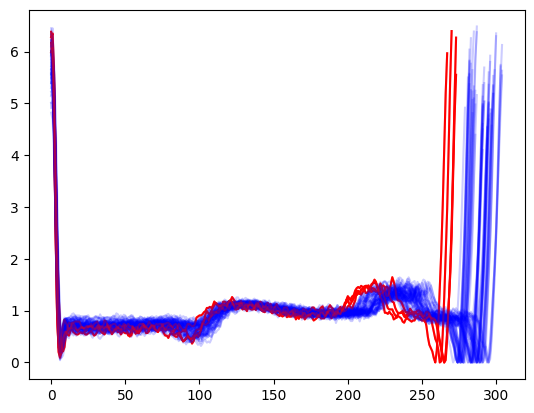

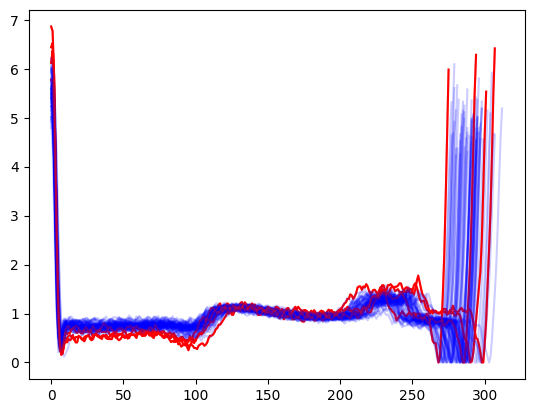

In [395]:
percentage: float = 0.025
non_percentage: float = 0.4-percentage

anomalies: np.ndarray = get_anomalies(euclidean_distances, percentage)
non_anomalies: np.ndarray = get_non_anomalies(euclidean_distances, non_percentage)

for id in anomalies:
    plt.plot(sections[id], c='red')
for id in non_anomalies:
    plt.plot(sections[id], c='blue', alpha=0.2)
for id in anomalies:
    plt.plot(sections[id], c='red', alpha=0.3)
plt.show()

anomalies: np.ndarray = get_anomalies(dtw_distances, percentage)
non_anomalies: np.ndarray = get_non_anomalies(dtw_distances, non_percentage)

for id in anomalies:
    plt.plot(sections[id], c='red')
for id in non_anomalies:
    plt.plot(sections[id], c='blue', alpha=0.2)
for id in anomalies:
    plt.plot(sections[id], c='red', alpha=0.3)
plt.show()

Number of sections: 196


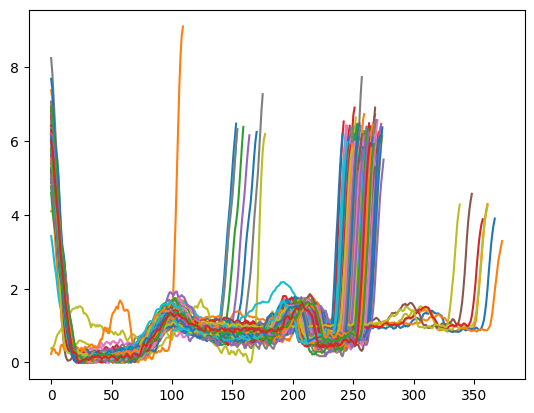

In [372]:
record: pd.DataFrame = records['105'].head(50000) ## Using only some of them
record = record.reset_index(names='timestamp')
series_used: np.ndarray = record['MLII'].to_numpy()

cycles = record.dropna()[1^record.dropna()['type'].isin([])].index.to_numpy()
print(f"Number of sections: {len(cycles)}")

sections: list[np.ndarray] = []
for i in range(1, len(cycles) - 1):
    sections.append(preprocess(series_used[cycles[i]:cycles[i+1]]))
    plt.plot(sections[-1])
plt.show()

In [373]:
euclidean_distances: np.ndarray = get_distance_matrix(sections, euclidean_ts)
dtw_distances: np.ndarray = get_distance_matrix(sections, dtw_ts)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

In [374]:
np.save("euclidean_distances105.npy", euclidean_distances)
np.save("dtw_distances105.npy", dtw_distances)

In [388]:
euclidean_distances = np.load("euclidean_distances105.npy")
dtw_distances = np.load("dtw_distances105.npy")

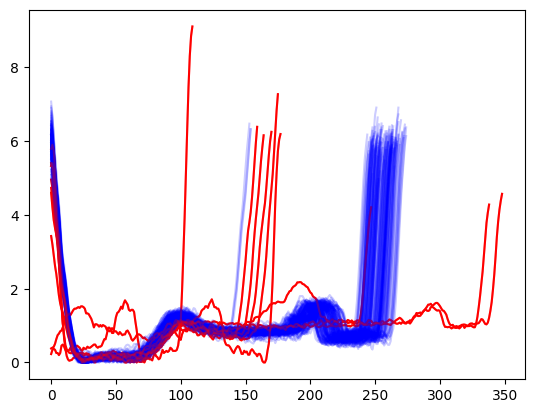

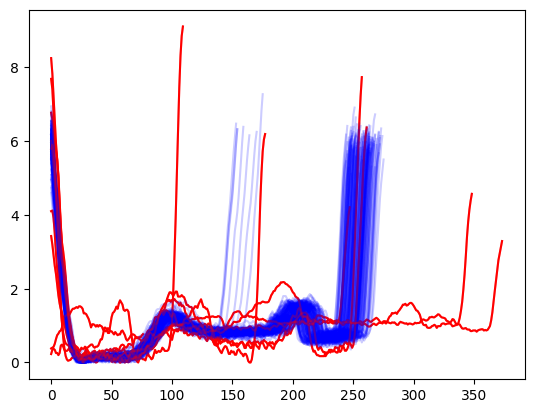

In [389]:
percentage: float = 0.05
non_percentage: float = 0.8-percentage
anomalies: np.ndarray = get_anomalies(euclidean_distances, percentage)
non_anomalies: np.ndarray = get_non_anomalies(euclidean_distances, non_percentage)

for id in anomalies:
    plt.plot(sections[id], c='red')
for id in non_anomalies:
    plt.plot(sections[id], c='blue', alpha=0.2)
for id in anomalies:
    plt.plot(sections[id], c='red', alpha=0.3)
plt.show()

anomalies: np.ndarray = get_anomalies(dtw_distances, percentage)
non_anomalies: np.ndarray = get_non_anomalies(dtw_distances, non_percentage)

for id in anomalies:
    plt.plot(sections[id], c='red')
for id in non_anomalies:
    plt.plot(sections[id], c='blue', alpha=0.2)
for id in anomalies:
    plt.plot(sections[id], c='red', alpha=0.3)
plt.show()